In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from random import seed
from random import random
from datetime import datetime
from numba import jit


#semilla para num aleatorios
now = datetime.now()
seed(now.microsecond)


#numero de pasos
@jit(nopython=False)
def norma(x,N):
    suma=0
    for i in range(N-1):
        suma=suma+(x[i]*x[i].conjugate()).real
    return suma
@jit(nopython=False)
def calc(phi,beta,alpha,chi,v,s,M):     ##función que calcula la parte principal
    for j in range (M-1):
        beta[M-2-j]=(4*1j*phi[M-1-j]/s-beta[M-1-j])/(-2+2*1j/s-v[M-1-j]+alpha[M-1-j])
        
    for j in range (M-1):
        chi[j+1]=alpha[j]*chi[j]+beta[j]
    
    for j in range(M):
        phi[j]=chi[j]-phi[j]

    return(phi,beta,chi)

#@jit(nopython=False)
def valoresp(phi,x):        ###funcion para calcular el valor esperado de la posición
    suma=0
    for i in range(N-1):
        suma=suma+(phi[i]*x[i]*phi[i].conjugate()).real
    return(suma)


#@jit(nopython=False)           #### funcion para calcular el valor esperado del momento, y las energías
def valorespmomento(phi,x):
    suma=0
    for i in range(N-1):
        suma=suma+(phi[i].conjugate()*x[i]).real
    return(suma)


def main(niteraciones,N,lambd,colapso,deteccion):
    
    #inicialización

    nc=N/4
    M=N-1
    alpha=np.zeros(M,dtype=complex)
    beta=np.zeros((M),dtype=complex)
    chi=np.zeros((M),dtype=complex)
    phi=np.zeros((N),dtype=complex)
    k0=2*math.pi*nc/N+0*1j
    s=0.25*k0*k0+0*1j
    v=np.zeros(N,dtype=complex)
    
    pd=np.zeros(niteraciones) ###probabilidad derecha para estudiar coeficiente de transmisión
    
    
    #### inicializacion de los valores esperados
    x_esp=np.zeros((niteraciones))
    p_m=np.zeros((N), dtype=complex)
    p_esp=np.zeros((niteraciones))
    phi_e=np.zeros((niteraciones+1,N),dtype=complex)
    e_esp=np.zeros((niteraciones))
    ec_m=np.zeros((N), dtype=complex)
    ec_esp=np.zeros((niteraciones))



    #inicializamos la funcion de onda y aplicamos condiciones de contorno
    for j in range(N-1):
        phi[j]=cmath.exp(1j*k0*j)*cmath.exp((-8*(4*j-N)**2)/(N*N))
    phi[0]=0
    phi[N-1]=0

    #normalizacion de la función de onda
    norma0=math.sqrt(norma(phi,N))
    for j in range(N-1):
        phi[j]=phi[j]/norma0
    
    
    for j in range(N):      ###inicializamos el potencial
        if((j>=2*N/5) & (j<=3*N/5)):
            v[j]=lambd*k0**2


   
    g=open("norma.txt","w")


    norep=True


    for j in range(M-1):
        alpha[M-2-j]=-1/(-2+2*1j/s-v[M-1-j]+alpha[M-1-j])

    maximo=False
    n=0
    while maximo==False :  
        
        aux=calc(phi,beta,alpha,chi,v,s,M)
        phi=aux[0]
        
        beta=aux[1]
        chi=aux[2]
        

        for j in range(N//5):
            pd[n]=pd[n]+((phi[4*N//5+j]*phi[4*N//5+j].conjugate()).real)
        

 
        if(n>0):
            if((pd[n]<pd[n-1]) and pd[n-1]>0.00001 and norep==True and colapso==True):   ### la segunda condicion es un poco arbitraria pero se utiliza para saltarse las posibles 
                if (deteccion==False):
                    norep=False             ###aquí calculamos el caso en el que la partícula no se detecta
                    itercolaps=n-1
                    normacolaps=math.sqrt(norma(phi,4*N//5))
                    for j in range(4*N//5-1):
                        phi[j]=phi[j]/normacolaps
                    for j in range(N//5):
                        phi[4*N//5+j]=0                            
                else:
                    norep=False             ###aquí calculamos el caso en el que la partícula se detecta
                    itercolaps=n-1
                    sumacolaps=0
                    for i in range(N//5-1):
                        sumacolaps=sumacolaps+(phi[4*N//5+i]*phi[4*N//5+i].conjugate()).real
                    normacolaps=math.sqrt(sumacolaps)    
                    for j in range(N//5-1):
                        phi[4*N//5+j]=phi[4*N//5+j]/normacolaps
                    for j in range(4*N//5):
                        phi[j]=0 


        #### valores esperados
        
        #### posición
        x=np.arange(0,N,1)
        x_esp[n]=valoresp(phi,x)
        
        #### momento
        for j in range(N-3):
            p_m[j+1]=-1j*(-phi[j]+phi[j+2])/2
        
        p_esp[n]=valorespmomento(phi,p_m)
        
        ##### energía cinética
        for j in range(N-3):
            ec_m[j+1]=-(phi[j]+phi[j+2]-2*phi[j+1])
        
        ec_esp[n]=valorespmomento(phi,ec_m)
        

        #### comprobación de que la norma se conserve 
        norma1=math.sqrt(norma(phi,N))
        print(norma1,file=g)
        
        
        phi_e[n]=phi   ####guardamos cada phi en una matriz para calcular el valor esperado de la energía

        


        n=n+1
        if(n==niteraciones):
            maximo=True

        


    
    g.close()

    ##valor esperado de E
    for j in range(niteraciones-1):
        aux1=phi_e[j+1]
        aux2=1j*0.5*(-phi_e[j]+phi_e[j+2])
        e_esp[j+1]=valorespmomento(aux1,aux2)
    
    
    
    
    return(x_esp,p_esp,e_esp,ec_esp)
   


Cuarto apartado

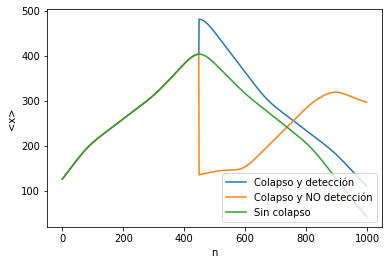

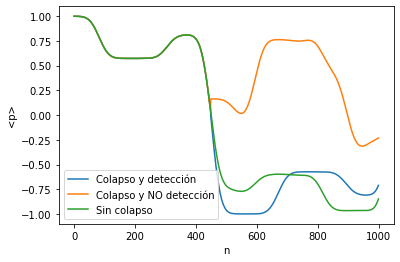

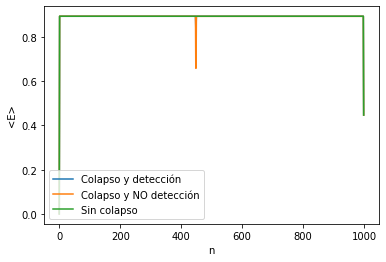

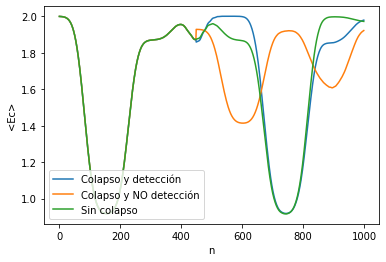

In [2]:
niteraciones=1000
N=500
lambd=0.5
colapso=True            #### True para que haya colapso de la función de onda y False para que no
deteccion=True           #### True para que la onda haya sido detectada, false para que no  


aux=main(niteraciones,N,lambd,colapso,True) ###la funcion de onda colapsa y es detectada
auxc2=main(niteraciones,N,lambd,False,False) ###la funcion de onda no colapsa
auxc=main(niteraciones,N,lambd,colapso,False)  ###la funcion de onda colapsa y no es detectada

x=np.arange(0,niteraciones)
fig, ax = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
fig, ax4 = plt.subplots()
ax.plot(x,aux[0],'-',label='Colapso y detección')
ax.plot(x,auxc[0],'-',label='Colapso y NO detección')
ax.plot(x,auxc2[0],'-',label='Sin colapso')

ax2.plot(x,aux[1],'-',label='Colapso y detección')
ax2.plot(x,auxc[1],'-',label='Colapso y NO detección')
ax2.plot(x,auxc2[1],'-',label='Sin colapso')

ax3.plot(x,aux[2],'-',label='Colapso y detección')
ax3.plot(x,auxc[2],'-',label='Colapso y NO detección')
ax3.plot(x,auxc2[2],'-',label='Sin colapso')

ax4.plot(x,aux[3],'-',label='Colapso y detección')
ax4.plot(x,auxc[3],'-',label='Colapso y NO detección')
ax4.plot(x,auxc2[3],'-',label='Sin colapso')

ax.set_xlabel('n')
ax2.set_xlabel('n')
ax3.set_xlabel('n')
ax4.set_xlabel('n')  # Add an x-label to the axes.

ax.set_ylabel('<x>')  # Add a y-label to the axes.
ax2.set_ylabel('<p>')
ax3.set_ylabel('<E>')
ax4.set_ylabel('<Ec>')

ax.legend(loc='lower right')
ax2.legend()
ax3.legend(loc='lower left')
ax4.legend(loc='lower left')